In [13]:
!pip install category_encoders
!pip install texthero

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 238 kB 9.9 MB/s 
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 10.4 MB 5.8 MB/s 
     |████████████████████████████████| 366 kB 3.4 MB/s 
     |████████████████████████████████| 24.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 11.1 MB/s 
     |████████████████████████████████| 82 kB 2.4 MB/s 
     |████████████████████████████████| 723 kB 15.3 MB/s 
     |████████████████████████████████| 293 kB 2.6 MB/s 
     |████████████████████████████████| 284 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 9.9 MB/s 
     |████████████████████████████████| 117 kB 17.9 MB/s 
  Cr

In [1]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import model_selection

In [2]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub23/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [3]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [4]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()

    idx_tbd = input_df['User_Score'] == 'tbd'
    output_df['User_Score_is_tbd'] = idx_tbd.astype(int)

    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    return output_df

def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count', 
        'User_Score', 
        'User_Count',
        'Year_of_Release',
        'User_Score_is_tbd'
    ]
    return input_df[use_columns].copy()

In [5]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()

    texts = [
        'japan', 'nintendo'
    ]

    for t in texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

In [6]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()

In [7]:
class CountEncodingBlock(BaseBlock):
    def __init__(self, column, whole_df: pd.DataFrame):
        self.column = column
        self.whole_df = whole_df

    def transform(self, input_df):
        output_df = pd.DataFrame()
        c = self.column

        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix('CE_')

In [8]:
class OneHotBlock(BaseBlock):
    def __init__(self, column: str):
        self.column = column
        self.cats_ = None

    def fit(self, input_df, y=None):
        vc = input_df[self.column].dropna().value_counts()
        cats = vc[vc > 40].index
        self.cats_ = cats
        return self.transform(input_df)

    def transform(self, input_df):
        x = pd.Categorical(input_df[self.column], categories=self.cats_)
        out_df = pd.get_dummies(x, dummy_na=False)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'OH_{self.column}=')

In [9]:
from textdistance import jaro
from nltk.util import ngrams

def line_ngram(line, n=2):
    words = [w for w in line.split(' ') if len(w) != 0] # 空文字は取り除く
    return list(ngrams(words, n))

In [10]:
def clearn_by_hero(x):
    custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords
                  ]
    return hero.clean(x, custom_pipeline)

def create_n_gram(x, n=3):
    x = clearn_by_hero(x)
    x = pd.Series(x).map(lambda r: line_ngram(r, n=n))
    return x

class NameNGramBlock(BaseBlock):
    def __init__(self, whole_df, n=3):
        self.whole_df = whole_df
        self.n = n

    def fit(self, input_df, y=None):
        name_grams = create_n_gram(self.whole_df['Name'], n=self.n)
        grams = [x for row in name_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(20).index

        self.top_grams_ = top_grams
        return self.transform(input_df)

    def transform(self, input_df):
        name_grams = create_n_gram(input_df['Name'], n=self.n)
        output_df = pd.DataFrame()

        for top in self.top_grams_:
            s_top = '-'.join(top)
            output_df[f'{s_top}'] = name_grams.map(lambda x: top in x).map(int)

        return output_df.add_prefix('Name_has_').add_suffix(f'_n={self.n}')

In [11]:
block = NameNGramBlock(train_df, n=3)
block.fit(train_df).head()

,Name_has_major-league-baseball_n=3,Name_has_grand-theft-auto_n=3,Name_has_super-robot-taisen_n=3,Name_has_wwe-smackdown-vs_n=3,Name_has_smackdown-vs-raw_n=3,Name_has_shin-megami-tensei_n=3,Name_has_lego-star-wars_n=3,Name_has_dragon-ball-z_n=3,Name_has_katekyoo-hitman-reborn_n=3,Name_has_star-wars-force_n=3,Name_has_marvel-super-heroes_n=3,Name_has_romance-three-kingdoms_n=3,Name_has_pachinko-pachi-slot_n=3,Name_has_lego-harry-potter_n=3,Name_has_mx-vs-atv_n=3,Name_has_pachi-slot-kouryaku_n=3,Name_has_hisshou-pachinko-pachi_n=3,Name_has_slot-kouryaku-series_n=3,Name_has_band-track-pack_n=3,Name_has_harry-potter-years_n=3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [12]:
sales_columns = train_df.columns[train_df.columns.str.contains('Sales')].tolist()
sales_columns = sorted(sales_columns)

In [13]:
key = 'Genre'

input_df = train_df
input_df[sales_columns].groupby(input_df[key]).sum()

,EU_Sales,Global_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,,
Action,30483,106343,10165,54010,11610
Adventure,4522,16634,3753,7229,1131
Fighting,5807,27258,5808,13313,2307
Misc,13411,48441,7803,22588,4601
Platform,16573,71149,12114,38119,4320
Puzzle,3871,19153,4497,9849,921
Racing,13039,44301,5026,21745,4465
Role-Playing,13536,72067,29886,24282,4348
Shooter,10890,43028,1964,26631,3506


In [14]:
class SalesPortfolioBlock(BaseBlock):
    """売上ポートフォリオ"""

    def __init__(self, key: str):
        self.key = key    
        self.meta_df = None

    def fit(self, input_df):
        _df = input_df[sales_columns].groupby(input_df[self.key]).sum()
        _df = (_df.T / _df.sum(axis=1)).T
        self.meta_df = _df
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
        out_df = out_df.add_prefix(f'SP@{self.key}_')
        return out_df

In [15]:
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function

    def transform(self, input_df):
        return self.function(input_df)

In [16]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [17]:
process_blocks = [
    WrapperBlock(create_continuous_features),
    WrapperBlock(create_boolean_feature),
    NameNGramBlock(whole_df, n=3),
    *[OneHotBlock(c) for c in ['Platform', 'Genre', 'Rating']],
    *[CountEncodingBlock(c, whole_df=whole_df) for c in ['Name', 'Platform', 'Year_of_Release']],
    *[SalesPortfolioBlock(c) for c in ['Genre']]
]

In [18]:
from tqdm import tqdm


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)


def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df


In [19]:
train_feat_df = to_feature(train_df, process_blocks, is_train=True)
test_feat_df = to_feature(test_df, process_blocks)

  0%|          | 0/10 [00:00<?, ?it/s]

create <__main__.WrapperBlock object at 0x7f226da3f470> 0.006[s]
create <__main__.WrapperBlock object at 0x7f226da3fcc0> 0.011[s]


  0%|          | 0/10 [00:00<?, ?it/s]

create <__main__.NameNGramBlock object at 0x7f226da3fef0> 0.306[s]
create <__main__.OneHotBlock object at 0x7f226da3fdd8> 0.003[s]
create <__main__.OneHotBlock object at 0x7f226da3f860> 0.002[s]
create <__main__.OneHotBlock object at 0x7f226da3f978> 0.002[s]
create <__main__.CountEncodingBlock object at 0x7f226da3f9b0> 0.006[s]
create <__main__.CountEncodingBlock object at 0x7f226da3fd68> 0.003[s]
create <__main__.CountEncodingBlock object at 0x7f226da3f7b8> 0.002[s]
create <__main__.SalesPortfolioBlock object at 0x7f226da3f358> 0.005[s]
create <__main__.WrapperBlock object at 0x7f226da3f470> 0.003[s]
create <__main__.WrapperBlock object at 0x7f226da3fcc0> 0.011[s]


100%|██████████| 10/10 [00:00<00:00, 43.15it/s]

create <__main__.NameNGramBlock object at 0x7f226da3fef0> 0.193[s]
create <__main__.OneHotBlock object at 0x7f226da3fdd8> 0.001[s]
create <__main__.OneHotBlock object at 0x7f226da3f860> 0.001[s]
create <__main__.OneHotBlock object at 0x7f226da3f978> 0.001[s]
create <__main__.CountEncodingBlock object at 0x7f226da3f9b0> 0.005[s]
create <__main__.CountEncodingBlock object at 0x7f226da3fd68> 0.003[s]
create <__main__.CountEncodingBlock object at 0x7f226da3f7b8> 0.002[s]
create <__main__.SalesPortfolioBlock object at 0x7f226da3f358> 0.002[s]


In [20]:
drop_c = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count',
       'Year_of_Release']
train_feat_df.drop(drop_c, axis=1, inplace=True)
test_feat_df.drop(drop_c, axis=1, inplace=True)
train_feat_df

,User_Score_is_tbd,Developer_has_japan,Developer_has_nintendo,Name_has_jikkyou-powerful-pro_n=3,Name_has_pro-evolution-soccer_n=3,Name_has_powerful-pro-yakyuu_n=3,Name_has_tiger-woods-pga_n=3,Name_has_woods-pga-tour_n=3,Name_has_dragon-ball-z_n=3,Name_has_yu-gi-oh_n=3,...,OH_Rating=M,OH_Rating=E10+,CE_Name,CE_Platform,CE_Year_of_Release,SP@Genre_EU_Sales,SP@Genre_Global_Sales,SP@Genre_JP_Sales,SP@Genre_NA_Sales,SP@Genre_Other_Sales
0,0,0,0,0,0,0,0,0,0,0,...,0,1,7,1320,NaN,0.143375,0.500176,0.047810,0.254032,0.054607
1,0,0,0,0,0,0,0,0,0,0,...,0,1,7,1320,NaN,0.143375,0.500176,0.047810,0.254032,0.054607
2,0,0,0,0,0,0,0,0,0,0,...,0,1,7,1209,NaN,0.143375,0.500176,0.047810,0.254032,0.054607
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,133,NaN,0.143375,0.500176,0.047810,0.254032,0.054607
4,0,0,0,0,0,0,0,0,0,0,...,0,1,8,1320,NaN,0.143375,0.500176,0.047810,0.254032,0.054607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,0,0,0,0,0,0,0,0,0,0,...,0,0,1,974,502.0,0.113941,0.500544,0.171945,0.182501,0.031070
8355,0,0,0,0,0,0,0,0,0,0,...,0,0,1,974,502.0,0.113941,0.500544,0.171945,0.182501,0.031070
8356,0,0,0,0,0,0,0,0,0,0,...,0,0,1,432,3.0,0.143375,0.500176,0.047810,0.254032,0.054607
8357,0,0,0,0,0,0,0,0,0,0,...,0,0,2,393,3.0,0.093922,0.500052,0.207370,0.168486,0.030170


In [21]:
train_feat_df.columns

Index(['User_Score_is_tbd', 'Developer_has_japan', 'Developer_has_nintendo',
       'Name_has_jikkyou-powerful-pro_n=3',
       'Name_has_pro-evolution-soccer_n=3', 'Name_has_powerful-pro-yakyuu_n=3',
       'Name_has_tiger-woods-pga_n=3', 'Name_has_woods-pga-tour_n=3',
       'Name_has_dragon-ball-z_n=3', 'Name_has_yu-gi-oh_n=3',
       'Name_has_major-league-baseball_n=3', 'Name_has_super-robot-taisen_n=3',
       'Name_has_metal-gear-solid_n=3', 'Name_has_mobile-suit-gundam_n=3',
       'Name_has_lego-star-wars_n=3', 'Name_has_mutant-ninja-turtles_n=3',
       'Name_has_teenage-mutant-ninja_n=3', 'Name_has_grand-theft-auto_n=3',
       'Name_has_wwe-smackdown-vs_n=3', 'Name_has_smackdown-vs-raw_n=3',
       'Name_has_shin-megami-tensei_n=3',
       'Name_has_dance-dance-revolution_n=3',
       'Name_has_tom-clancy-splinter_n=3', 'OH_Platform=DS', 'OH_Platform=PS2',
       'OH_Platform=Wii', 'OH_Platform=PS3', 'OH_Platform=PSP',
       'OH_Platform=X360', 'OH_Platform=PS', 'OH_Platfo

In [22]:
train_column = train_df.columns

In [23]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [24]:
train_df_drop = train_df[X_column]

In [25]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [26]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
whole_df = pd.concat([train_df_drop, test_df], ignore_index=True)

In [28]:
year_mean = whole_df.groupby('Platform').mean()['Year_of_Release'].astype('int')
year_mean.name = 'Year_Mean'

In [29]:
# whole_df = pd.merge(whole_df, year_mean, on='Platform', how='left')
# whole_df['Year_of_Release'].fillna(whole_df['Year_Mean'], inplace=True)
# whole_df.drop('Year_Mean', axis=1, inplace=True)

# train_df_drop = whole_df.iloc[:len(train_df_drop), :]
# test_df = whole_df.iloc[len(train_df_drop):, :]


In [30]:
def add_pub_dev_info(df1, df2, tgt, col, val='Name', func='count'):
    whole_df = pd.concat([df1, df2], ignore_index=True)
    plat_pivot = whole_df.pivot_table(index=tgt, columns=col, values=val, aggfunc=func).reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 5
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:3] +  '_' + col+ '_' + val + '_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    whole_df = pd.merge(whole_df, plat_pca_df, on=tgt, how='left')

    df1 = whole_df.iloc[:len(df1), :]
    df2 = whole_df.iloc[len(df1):, :]
    return df1, df2



In [31]:
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Platform')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Genre')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Rating')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Critic_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Critic_Count')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'User_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'User_Count')

train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Platform')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Genre')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Rating')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Critic_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Critic_Count')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'User_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'User_Count')

train_df_drop

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,...,Dev_Genre_Name_pca_0,Dev_Genre_Name_pca_1,Dev_Genre_Name_pca_2,Dev_Genre_Name_pca_3,Dev_Genre_Name_pca_4,Dev_Rating_Name_pca_0,Dev_Rating_Name_pca_1,Dev_Rating_Name_pca_2,Dev_Rating_Name_pca_3,Dev_Rating_Name_pca_4
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,74.0,17.0,7.9,22.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,78.0,22.0,6.6,28.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,73.0,5.0,7.4,10.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
3,Combat,2600,NaN,Action,Atari,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,76.0,8.0,7.8,13.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,78.0,57.0,8,569.0,Paradox Development Studio,...,-1.257383,-1.275148,-0.316958,-0.340787,-0.374459,-2.262654,-0.232654,1.623968,-0.834035,-0.005679
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# cols = 'Name_0'
# fig, ax = plt.subplots(figsize = (16, 6))

# sns.distplot(train_df_drop['Pu_Critic_Score_pca_0'].values, 
#              hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
# sns.distplot(test_df['Pu_Critic_Score_pca_0'].values, 
#              hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
# ax.set_title(f'Distribution for {cols}', fontsize=16)
# sns.despine(left=True, bottom=True)
# plt.legend()
# plt.show()

In [33]:
# train_df_drop

In [34]:
# plt.plot(train_df_drop['plat_pca_1'])
# plt.plot(train_df_drop['plat_pca_0'])
# plt.plot(train_df_drop['Publisher'])

In [35]:
# plt.plot(train_df_drop['Publisher'])

In [36]:
# train_df_drop

In [37]:
# Ratingの変換

In [38]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [39]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [40]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [41]:
def translate_name(df1, df2):
    df = pd.concat([df1, df2])
    tif_vec = hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline))
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline)))
    tif_vec_l = []
    for i in range(len(tif_vec)):
        tif_vec_l.append(tif_vec.values[i])
    tif_vec_np = np.array(tif_vec_l)

#     km = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
#     y_km = km.fit_predict(tif_vec_np)
#     df['kmeans_name'] = y_km
    
    pca = PCA(n_components=30)
    tif_vec_pca = pca.fit_transform(tif_vec_np) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     tif_vec_pca = tsne.fit_transform(tif_vec_np)
    
    for i in range(tif_vec_pca.shape[1]):
        c_ = 'Name_' + str(i)
        df[c_] = tif_vec_pca[:, i]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [42]:
train_df_drop, test_df = translate_name(train_df_drop, test_df)


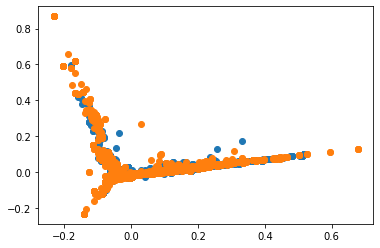

In [43]:
plt.scatter(train_df_drop['Name_0'].values, train_df_drop['Name_1'].values)
plt.scatter(test_df['Name_0'].values, test_df['Name_1'].values)

In [44]:
def translate_name_wav2vec(df1, df2):
    df = pd.concat([df1, df2])
    C_Name = hero.clean(df['Name'], pipeline=custom_pipeline)
    sentences = []
    for sentence in C_Name:
        data = sentence.split()
        sentences.append(data)
    model = word2vec.Word2Vec(sentences,
                              size=200,
                              min_count=1,
                              window=5,
                              iter=20,
                              sg = 0)
    w_vec = []
    for sentence in C_Name:
        data = sentence.split()
        tmp = np.zeros(200)
        for d in data:
            tmp += model[d]
        w_vec.append(tmp)
    w_vec = np.array(w_vec)
    
    pca = PCA(n_components=30)
    w_vec_pca = pca.fit_transform(w_vec) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     w_vec_pca = tsne.fit_transform(w_vec_pca)
    for i in range(w_vec_pca.shape[1]):
        c_ = 'W_Name_' + str(i)
        df[c_] = w_vec_pca[:, i]
        
        
        
#     pca = PCA(n_components=10)
#     w_vec_pca = pca.fit_transform(w_vec)
    
#     df['Name_0'] = w_vec_pca[:, 0]
#     df['Name_1'] = w_vec_pca[:, 1]
#     df['Name_2'] = w_vec_pca[:, 2]
#     df['Name_3'] = w_vec_pca[:, 3]
#     df['Name_4'] = w_vec_pca[:, 4]
#     df['Name_5'] = w_vec_pca[:, 5]
#     df['Name_6'] = w_vec_pca[:, 6]
#     df['Name_7'] = w_vec_pca[:, 7]
#     df['Name_8'] = w_vec_pca[:, 8]
#     df['Name_9'] = w_vec_pca[:, 9]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [45]:
train_df_drop, test_df = translate_name_wav2vec(train_df_drop, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [46]:
def add_pub_dev_info_mean(df1, df2, tgt, col, val, func=np.mean):
    whole_df = pd.concat([df1, df2], ignore_index=True)
    plat_pivot = whole_df.pivot_table(index=tgt, columns=col, values=val, aggfunc=func).reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 5
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:3] +  '_' + col+ '_' + val + '_pca_mean'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    whole_df = pd.merge(whole_df, plat_pca_df, on=tgt, how='left')

    df1 = whole_df.iloc[:len(df1), :]
    df2 = whole_df.iloc[len(df1):, :]
    return df1, df2

In [47]:
for i in range(30):
    train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Genre', 'Name_'+str(i))
train_df_drop
for i in range(30):
    train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Platform', 'Name_'+str(i))
train_df_drop
for i in range(30):
    train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Rating', 'Name_'+str(i))
# train_df_drop

# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Genre', 'W_Name_'+str(i))
# train_df_drop
# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Platform', 'W_Name_'+str(i))
# train_df_drop
# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Rating', 'W_Name_'+str(i))
    
# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Developer', 'Genre', 'Name_'+str(i))
# train_df_drop
# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Developer', 'Platform', 'Name_'+str(i))
# train_df_drop
# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Developer', 'Rating', 'Name_'+str(i))
# # train_df_drop

# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Developer', 'Genre', 'W_Name_'+str(i))
# train_df_drop
# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Developer', 'Platform', 'W_Name_'+str(i))
# train_df_drop
# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Developer', 'Rating', 'W_Name_'+str(i))
# # train_df_drop

In [48]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Pub_Platform_Name_pca_0,Pub_Platform_Name_pca_1,...,Pub_Rating_Name_28_pca_mean0,Pub_Rating_Name_28_pca_mean1,Pub_Rating_Name_28_pca_mean2,Pub_Rating_Name_28_pca_mean3,Pub_Rating_Name_28_pca_mean4,Pub_Rating_Name_29_pca_mean0,Pub_Rating_Name_29_pca_mean1,Pub_Rating_Name_29_pca_mean2,Pub_Rating_Name_29_pca_mean3,Pub_Rating_Name_29_pca_mean4
0,1.0,NaN,1.0,74.0,17.0,7.9,22.0,1.0,48.983372,-21.987509,...,-0.098165,0.019059,-0.055966,-0.027226,0.029021,-0.096637,0.139607,0.024277,0.005093,0.002396
1,1.0,NaN,1.0,78.0,22.0,6.6,28.0,1.0,19.845629,2.303901,...,0.012357,-0.005715,-0.041282,0.004144,-0.000527,-0.025582,0.038294,0.044515,-0.000102,0.000451
2,2.0,NaN,1.0,73.0,5.0,7.4,10.0,1.0,48.983372,-21.987509,...,-0.098165,0.019059,-0.055966,-0.027226,0.029021,-0.096637,0.139607,0.024277,0.005093,0.002396
3,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,87.992511,-5.615959,...,-0.006271,-0.000193,-0.013501,-0.004699,-0.000536,0.006016,-0.005347,-0.001866,0.002779,-0.000261
4,1.0,NaN,1.0,76.0,8.0,7.8,13.0,1.0,48.983372,-21.987509,...,-0.098165,0.019059,-0.055966,-0.027226,0.029021,-0.096637,0.139607,0.024277,0.005093,0.002396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,9.0,2016.0,12.0,78.0,57.0,8,569.0,NaN,-3.029079,-0.973596,...,-0.014843,-0.008318,-0.005263,-0.007312,-0.000806,-0.007011,-0.004722,-0.004603,0.002855,0.008640
8355,9.0,2016.0,12.0,NaN,NaN,NaN,NaN,NaN,-3.591453,-0.481136,...,-0.030645,-0.016549,-0.006680,0.003517,-0.000364,0.020262,-0.016036,-0.004332,-0.000973,-0.000452
8356,14.0,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,23.709706,23.341467,...,-0.017980,0.006555,-0.005613,0.001889,-0.000372,0.002163,-0.007718,-0.000475,-0.004488,-0.000309
8357,30.0,2017.0,8.0,NaN,NaN,NaN,NaN,NaN,146.907780,-5.172567,...,-0.003586,-0.002205,0.012547,-0.004625,-0.000169,-0.001795,-0.000206,0.004427,-0.000280,-0.000179


In [49]:
test_df.reset_index(drop=True, inplace=True)

In [50]:
train_df_drop = pd.concat([train_df_drop, train_feat_df], axis=1)
test_df = pd.concat([test_df, test_feat_df], axis=1)

In [51]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [52]:
X = train_df_drop
y = train_df['Global_Sales'].astype('float64')
groups = train_df['Publisher']

In [53]:
def create_folds(data, target_col):
    num_bins = np.int(1 + np.log2(len(data)))
    bins = pd.cut(
        data[target_col],
        bins=num_bins,
        labels=False
    )
    kf = model_selection.StratifiedKFold(n_splits=10)
    fold_ids = list(kf.split(X=data, y=bins.values))
    return fold_ids

fold_ids = create_folds(train_df, "Global_Sales")

/home/user/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



In [ ]:

# kfoldの分割数
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
               'max_dapth': 8,
              "learning_rate": 0.01,
               'colsample_bytree': 0.8}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        num_boost_round=10000,
                        early_stopping_rounds=1000,
                        verbose_eval=200)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'epoch: {i} RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.859706	valid_0's rmse: 0.961144
[400]	training's rmse: 0.733953	valid_0's rmse: 0.881677
[600]	training's rmse: 0.663374	valid_0's rmse: 0.84986
[800]	training's rmse: 0.613548	valid_0's rmse: 0.835269
[1000]	training's rmse: 0.573691	valid_0's rmse: 0.827726
[1200]	training's rmse: 0.538645	valid_0's rmse: 0.822593
[1400]	training's rmse: 0.508077	valid_0's rmse: 0.81853
[1600]	training's rmse: 0.480527	valid_0's rmse: 0.814966
[1800]	training's rmse: 0.454969	valid_0's rmse: 0.812998
[2000]	training's rmse: 0.431499	valid_0's rmse: 0.81103
[2200]	training's rmse: 0.410044	valid_0's rmse: 0.809483
[2400]	training's rmse: 0.390579	valid_0's rmse: 0.808705
[2600]	training's rmse: 0.372607	valid_0's rmse: 0.808425
[2800]	training's rmse: 0.355823	valid_0's rmse: 0.807881
[3000]	training's rmse: 0.340482	valid_0's rmse: 0.807666
[3200]	training's rmse: 0.326876	valid_0's rmse: 0.806167
[3400]	training'

In [ ]:
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

In [ ]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof23.csv", index = False)

In [ ]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [ ]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub23.csv", index = False)

In [70]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

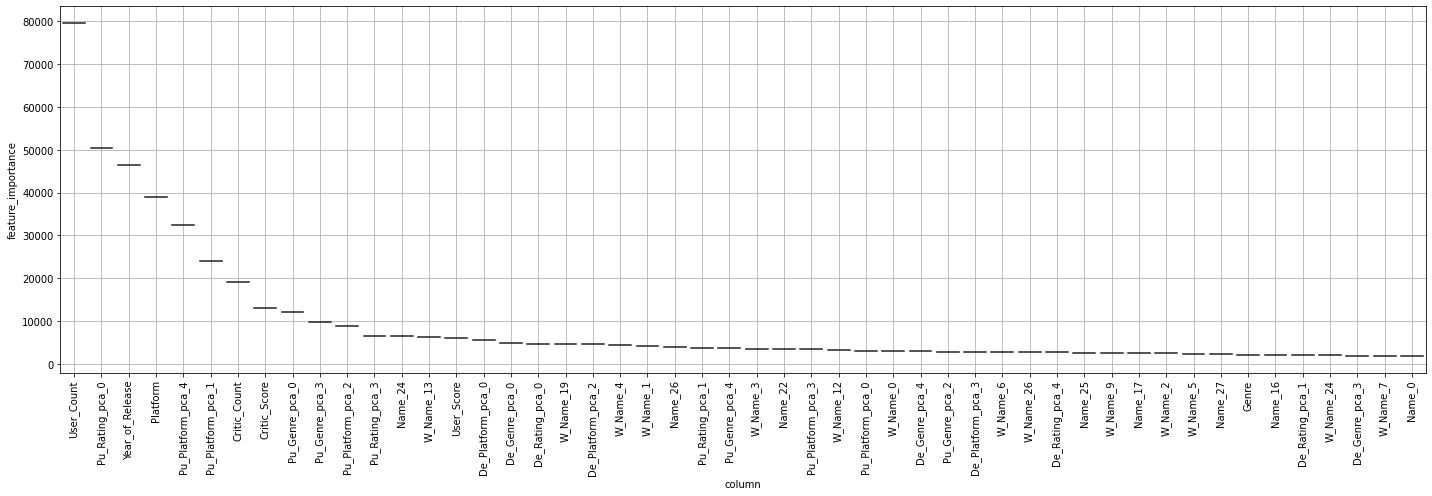

In [71]:
fig, ax = visualize_importance(model, X)


In [72]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Name_2,323.877692
Pu_Genre_pca_1,496.322214
Name_7,515.143147
De_Rating_pca_3,518.100210
De_Genre_pca_1,616.086339
...,...
Pu_Platform_pca_4,32338.678168
Platform,38917.579210
Year_of_Release,46552.477817
Pu_Rating_pca_0,50343.438889


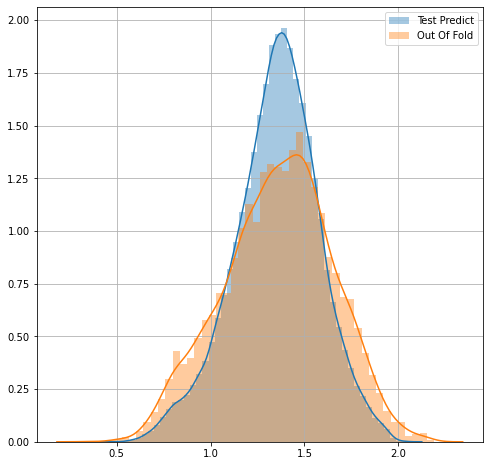

In [66]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred_test_np), label='Test Predict')
sns.distplot(np.log1p(oof_pred), label='Out Of Fold')
ax.legend()
ax.grid()

<AxesSubplot:>

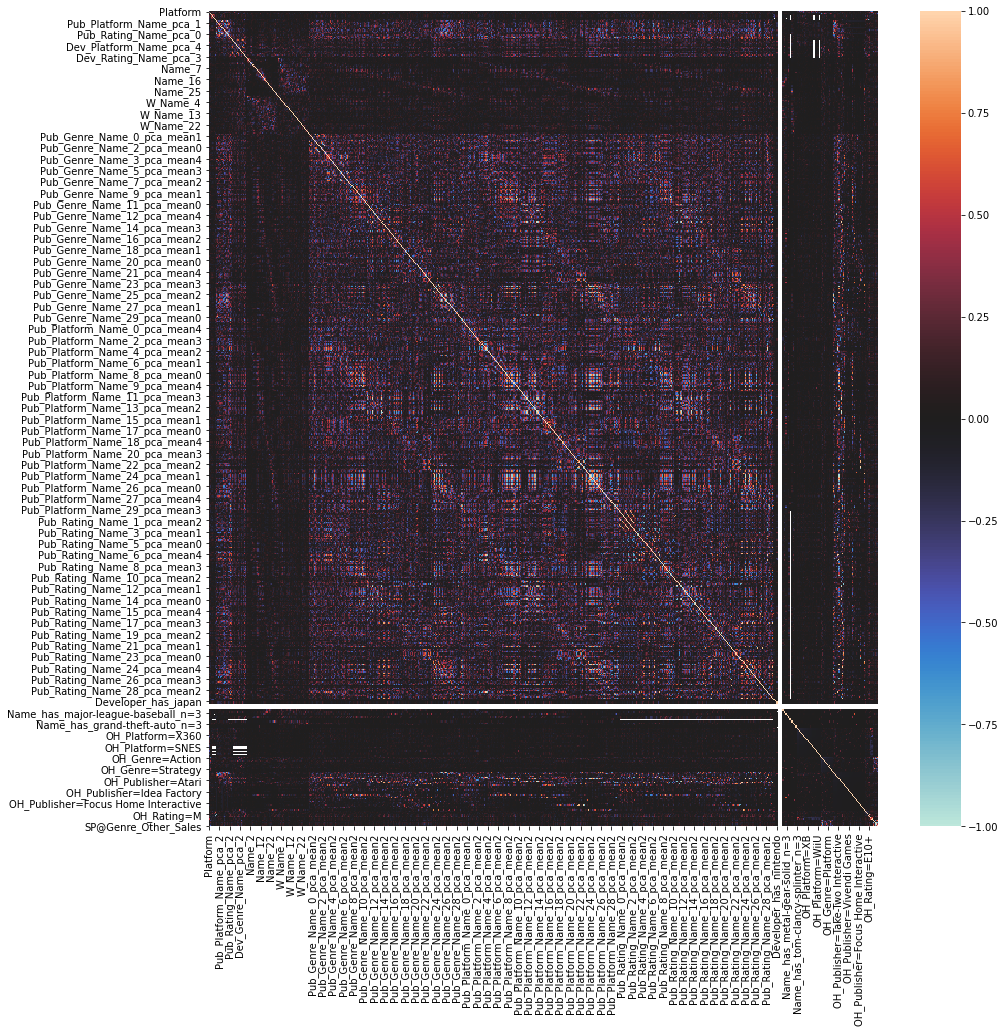

In [54]:
plt.figure(figsize=(15,15))
sns.heatmap(train_df_drop.corr(), vmax=1, vmin=-1, center=0)
# train_df_drop.corr().style.background_gradient(axis=None)